In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
import nltk

In [2]:
from konlpy.tag import Kkma
from konlpy.utils import pprint
from konlpy.corpus import kolaw
from nltk import collocations

# http://kkma.snu.ac.kr/documents/?doc=postag << 한글 형태소 품사 태그표
# https://wikidocs.net/21698 << 자연어처리 참고 블로그
# https://konlpy.org/en/latest/api/konlpy.tag/ << okt, mecab
# https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html << konlpy 로 감정분석

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
plt.rc('font', family='NanumGothic')
%matplotlib inline

In [4]:
kkma = Kkma()

pprint(kkma.nouns(u'드디어 오류 없이 잘 실행됩니다. 오늘은 여기까지 안녕'))
print(kkma.nouns('드디어 오류없이 잘 실행됩니다. 췤!'))
# 차이는 뭔지 모르겟음
# >>> ['오류', '실행', '오늘', '여기', '안녕']

['오류', '실행', '오늘', '여기', '안녕']
['오류', '실행', '췤']


In [5]:
from konlpy.tag import Okt

In [6]:
okt = Okt()

pprint(okt.nouns(u'드디어 오류 없이 잘 실행됩니다. 오늘은 여기까지 안녕'))
print(okt.nouns('드디어 오류없이 잘 실행됩니다. 췤!'))
# 차이는 뭔지 모르겟음
# >>> ['오류', '실행', '오늘', '여기', '안녕']

['오류', '실행', '오늘', '여기', '안녕']
['오류', '실행', '췤']


In [7]:
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))
print(kkma.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]
[('이', 'MDT'), ('밤', 'NNG'), ('그날', 'NNG'), ('의', 'JKG'), ('반딧불', 'NNG'), ('을', 'JKO'), ('당신', 'NP'), ('의', 'JKG'), ('창', 'NNG'), ('가까이', 'MAG'), ('보내', 'VV'), ('ㄹ게요', 'EFN')]


In [9]:
law_df = pd.read_csv("D:/Programming/2020.11.AIcompet/law_preprocessing1.csv", sep=",", encoding="CP949")
law_df = law_df.drop(columns='Unnamed: 0')
law_df

,선고일자,법원명,사건명,주문,이유,주문 토큰화,승소여부,이유토큰화1
0,2020.10.15,0,부당징계및부···[행정],"상고를 모두 기각한다. 상고비용 중 피고의 상고로 인한 부분은 피고가, 피고 보조참...","... 원고 F, G가 ‘순환전보 관련 사업소장 폭행’ 행위를 했다는 이유로 징계를...","['상고', '기각', '상고비용', '비용', '중', '피고', '부분', '고...",0,"['... 원고 F, G가 ‘ 순환 전보 관련 사업 소장 폭행’ 행위를 했다는 이유..."
1,2020.10.14,1,급여지급[민사],"피고는 원고에게 58,580,000원과 이에 대한 2019. 2. 14.부터 202...","... 학생들을 상대로 실시된 학교폭력(성폭력) 피해에 대한 설문조사 결과, ‘어깨...","['원고', '58,580,000', '58,580,000원', '원', '대한',...",1,"['... 학생들을 상대로 실시된 학교폭력( 성폭력) 피해에 대한 설문조사 결과, ..."
2,2020.10.14,2,손해배상(기···[민사],"1. 당심에서 확장된 원고의 청구에 따라 제1심판결의 주문 제1, 2항을 다음과 같...","... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고 보인다. 이와...","['1', '당', '당심', '심', '확장', '원고', '청구', '저', '...",1,"['... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고', '보인..."
3,2020.10.14,3,명의이전등록···[민사],"1. 피고는 원고에게, 가. 별지 목록 기재 자동차에 관하여 구미시 차량등록사업소 ...","... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고 진술하였으며, 이 사건....","['1', '원고', '별지', '목록', '기재', '자동차', '구미', '구미...",1,"['... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고', '진술하였으며, ..."
4,2020.10.08,4,정직처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,"..., 성범죄, 금품수수, 상해ㆍ폭행) 근절 추진계획의 일환으로 비위공무원에 대한...","['원고', '청구', '기각', '소송비', '부담']",0,"['..., 성범죄, 금품수수, 상해 ㆍ 폭행) 근절 추진계획의 일환으로 비위공무원..."
...,...,...,...,...,...,...,...,...
4090,2018.11.15,25,학교폭력 징···[행정],1. 피고의 항소를 기각한다. 2. 항소비용은 피고가 부담한다. 청구취지 및 항소취...,... 한다)은 이 사건 폭행에 관하여 다음과 같은 학교폭력사안조사 공동 보고서를....,"['1', '피고', '항소', '기각', '2', '항소비용', '비용', '부담...",0,['... 한다) 은 이 사건 폭행에 관하여 다음과 같은 학교폭력 사안 조사 공동 ...
4091,2018.11.15,4,손해배상(기···[민사],1. 항소를 기각한다. 2. 항소비용은 원고가 부담한다. 청구취지 및 항소취지 제1...,... 등 원고의 험담을 하고 손님들에게 폭행을 가하는 등 원고의 영업을 방해하였으...,"['1', '항소', '기각', '2', '항소비용', '비용', '원고', '부담...",0,['... 등 원고의 험담을 하고 손님들에게 폭행을 가하는 등 원고의 영업을 방해하...
4092,2018.11.15,19,손해배상(기···[민사],1. 피고의 항소를 기각한다. 2. 항소비용은 피고가 부담한다. 청구취지 및 항소취...,"... 붙게 되어 다투는 과정에서 피고가 원고를 폭행하게 된 것으로, 원고가 불법행...","['1', '피고', '항소', '기각', '2', '항소비용', '비용', '부담...",0,"['... 붙게 되어 다투는 과정에서 피고가 원고를 폭행하게 된 것으로, 원고가 불..."
4093,2018.11.15,18,손해배상(기···[민사],1. 제1심판결의 원고 B에 대한 부분 중 아래에서 지급을 명하는 금액을 초과하는 ...,"... C, 피고인 D, 피고인 E의 폭력... 공동하여 피해자에게 폭행을 가하였다...","['1', '저', '1심판결', '심', '판결', '원고', '부분', '중',...",1,"['... C, 피고인 D, 피고인 E의 폭력... 공동하여 피해자에게 폭행을 가하..."


In [14]:
print(okt.pos(law_df['주문'].loc[0]))

[('상고', 'Noun'), ('를', 'Josa'), ('모두', 'Noun'), ('기각', 'Noun'), ('한', 'Josa'), ('다', 'Adverb'), ('.', 'Punctuation'), ('상고', 'Noun'), ('비용', 'Noun'), ('중', 'Noun'), ('피고', 'Noun'), ('의', 'Josa'), ('상고', 'Noun'), ('로', 'Josa'), ('인한', 'Adjective'), ('부분', 'Noun'), ('은', 'Josa'), ('피고', 'Noun'), ('가', 'Josa'), (',', 'Punctuation'), ('피고', 'Noun'), ('보조참가인', 'Noun'), ('의', 'Josa'), ('...', 'Punctuation')]


In [15]:
print(kkma.pos(law_df['주문'].loc[0]))

[('상고', 'NNG'), ('를', 'JKO'), ('모두', 'MAG'), ('기각', 'NNG'), ('하', 'XSV'), ('ㄴ다', 'EFN'), ('.', 'SF'), ('상고', 'NNG'), ('비용', 'NNG'), ('중', 'NNB'), ('피고', 'NNG'), ('의', 'JKG'), ('상고', 'NNG'), ('로', 'JKM'), ('인하', 'VV'), ('ㄴ', 'ETD'), ('부분', 'NNG'), ('은', 'JX'), ('피', 'XPN'), ('고가', 'NNG'), (',', 'SP'), ('피고', 'NNG'), ('보조', 'NNG'), ('참가', 'NNG'), ('인의', 'NNG'), ('...', 'SE')]


In [18]:
temp1 = law_df['이유']
temp2 = []
for i in temp1:
    temp2.append(okt.pos(i))

# 3분 걸림 시방거~
# kkma 쓰지말자~ 느리고 성능도 별로다

[[('...', 'Punctuation'),
  ('원고', 'Noun'),
  ('F', 'Alpha'),
  (',', 'Punctuation'),
  ('G', 'Alpha'),
  ('가', 'Verb'),
  ('‘', 'Foreign'),
  ('순환', 'Noun'),
  ('전보', 'Noun'),
  ('관련', 'Noun'),
  ('사업', 'Noun'),
  ('소장', 'Noun'),
  ('폭행', 'Noun'),
  ('’', 'Punctuation'),
  ('행위', 'Noun'),
  ('를', 'Josa'),
  ('했다는', 'Verb'),
  ('이유', 'Noun'),
  ('로', 'Josa'),
  ('징계', 'Noun'),
  ('를', 'Josa'),
  ('하였을', 'Verb'),
  ('뿐', 'Noun'),
  ('...', 'Punctuation'),
  ('더', 'Noun'),
  ('보기', 'Noun'),
  ('...', 'Punctuation'),
  ('같은', 'Adjective'),
  ('이유', 'Noun'),
  ('로', 'Josa'),
  ('원고', 'Noun'),
  ('A', 'Alpha'),
  (',', 'Punctuation'),
  ('B', 'Alpha'),
  (',', 'Punctuation'),
  ('C', 'Alpha'),
  (',', 'Punctuation'),
  ('I', 'Alpha'),
  (',', 'Punctuation'),
  ('J', 'Alpha'),
  (',', 'Punctuation'),
  ('K', 'Alpha'),
  (',', 'Punctuation'),
  ('L', 'Alpha'),
  (',', 'Punctuation'),
  ('N', 'Alpha'),
  ('에', 'Josa'),
  ('대한', 'Noun'),
  ('각', 'Noun'),
  ('징계', 'Noun'),
  ('는', 'Josa'),
  ('징

In [26]:
temp2[:5]

[[('...', 'Punctuation'),
  ('원고', 'Noun'),
  ('F', 'Alpha'),
  (',', 'Punctuation'),
  ('G', 'Alpha'),
  ('가', 'Verb'),
  ('‘', 'Foreign'),
  ('순환', 'Noun'),
  ('전보', 'Noun'),
  ('관련', 'Noun'),
  ('사업', 'Noun'),
  ('소장', 'Noun'),
  ('폭행', 'Noun'),
  ('’', 'Punctuation'),
  ('행위', 'Noun'),
  ('를', 'Josa'),
  ('했다는', 'Verb'),
  ('이유', 'Noun'),
  ('로', 'Josa'),
  ('징계', 'Noun'),
  ('를', 'Josa'),
  ('하였을', 'Verb'),
  ('뿐', 'Noun'),
  ('...', 'Punctuation'),
  ('더', 'Noun'),
  ('보기', 'Noun'),
  ('...', 'Punctuation'),
  ('같은', 'Adjective'),
  ('이유', 'Noun'),
  ('로', 'Josa'),
  ('원고', 'Noun'),
  ('A', 'Alpha'),
  (',', 'Punctuation'),
  ('B', 'Alpha'),
  (',', 'Punctuation'),
  ('C', 'Alpha'),
  (',', 'Punctuation'),
  ('I', 'Alpha'),
  (',', 'Punctuation'),
  ('J', 'Alpha'),
  (',', 'Punctuation'),
  ('K', 'Alpha'),
  (',', 'Punctuation'),
  ('L', 'Alpha'),
  (',', 'Punctuation'),
  ('N', 'Alpha'),
  ('에', 'Josa'),
  ('대한', 'Noun'),
  ('각', 'Noun'),
  ('징계', 'Noun'),
  ('는', 'Josa'),
  ('징

In [22]:
law_df['이유토큰화2'] = temp2
law_df

,선고일자,법원명,사건명,주문,이유,주문 토큰화,승소여부,이유토큰화1,이유토큰화2
0,2020.10.15,0,부당징계및부···[행정],"상고를 모두 기각한다. 상고비용 중 피고의 상고로 인한 부분은 피고가, 피고 보조참...","... 원고 F, G가 ‘순환전보 관련 사업소장 폭행’ 행위를 했다는 이유로 징계를...","['상고', '기각', '상고비용', '비용', '중', '피고', '부분', '고...",0,"['... 원고 F, G가 ‘ 순환 전보 관련 사업 소장 폭행’ 행위를 했다는 이유...","[(..., Punctuation), (원고, Noun), (F, Alpha), (..."
1,2020.10.14,1,급여지급[민사],"피고는 원고에게 58,580,000원과 이에 대한 2019. 2. 14.부터 202...","... 학생들을 상대로 실시된 학교폭력(성폭력) 피해에 대한 설문조사 결과, ‘어깨...","['원고', '58,580,000', '58,580,000원', '원', '대한',...",1,"['... 학생들을 상대로 실시된 학교폭력( 성폭력) 피해에 대한 설문조사 결과, ...","[(..., Punctuation), (학생, Noun), (들, Suffix), ..."
2,2020.10.14,2,손해배상(기···[민사],"1. 당심에서 확장된 원고의 청구에 따라 제1심판결의 주문 제1, 2항을 다음과 같...","... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고 보인다. 이와...","['1', '당', '당심', '심', '확장', '원고', '청구', '저', '...",1,"['... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고', '보인...","[(..., Punctuation), (한, Verb), (사실, Noun), (이..."
3,2020.10.14,3,명의이전등록···[민사],"1. 피고는 원고에게, 가. 별지 목록 기재 자동차에 관하여 구미시 차량등록사업소 ...","... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고 진술하였으며, 이 사건....","['1', '원고', '별지', '목록', '기재', '자동차', '구미', '구미...",1,"['... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고', '진술하였으며, ...","[(..., Punctuation), (항의, Noun), (하였고, Verb), ..."
4,2020.10.08,4,정직처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,"..., 성범죄, 금품수수, 상해ㆍ폭행) 근절 추진계획의 일환으로 비위공무원에 대한...","['원고', '청구', '기각', '소송비', '부담']",0,"['..., 성범죄, 금품수수, 상해 ㆍ 폭행) 근절 추진계획의 일환으로 비위공무원...","[(...,, Punctuation), (성범죄, Noun), (,, Punctua..."
...,...,...,...,...,...,...,...,...,...
4090,2018.11.15,25,학교폭력 징···[행정],1. 피고의 항소를 기각한다. 2. 항소비용은 피고가 부담한다. 청구취지 및 항소취...,... 한다)은 이 사건 폭행에 관하여 다음과 같은 학교폭력사안조사 공동 보고서를....,"['1', '피고', '항소', '기각', '2', '항소비용', '비용', '부담...",0,['... 한다) 은 이 사건 폭행에 관하여 다음과 같은 학교폭력 사안 조사 공동 ...,"[(..., Punctuation), (한다, Verb), (), Punctuati..."
4091,2018.11.15,4,손해배상(기···[민사],1. 항소를 기각한다. 2. 항소비용은 원고가 부담한다. 청구취지 및 항소취지 제1...,... 등 원고의 험담을 하고 손님들에게 폭행을 가하는 등 원고의 영업을 방해하였으...,"['1', '항소', '기각', '2', '항소비용', '비용', '원고', '부담...",0,['... 등 원고의 험담을 하고 손님들에게 폭행을 가하는 등 원고의 영업을 방해하...,"[(..., Punctuation), (등, Noun), (원고, Noun), (의..."
4092,2018.11.15,19,손해배상(기···[민사],1. 피고의 항소를 기각한다. 2. 항소비용은 피고가 부담한다. 청구취지 및 항소취...,"... 붙게 되어 다투는 과정에서 피고가 원고를 폭행하게 된 것으로, 원고가 불법행...","['1', '피고', '항소', '기각', '2', '항소비용', '비용', '부담...",0,"['... 붙게 되어 다투는 과정에서 피고가 원고를 폭행하게 된 것으로, 원고가 불...","[(..., Punctuation), (붙게, Verb), (되어, Verb), (..."
4093,2018.11.15,18,손해배상(기···[민사],1. 제1심판결의 원고 B에 대한 부분 중 아래에서 지급을 명하는 금액을 초과하는 ...,"... C, 피고인 D, 피고인 E의 폭력... 공동하여 피해자에게 폭행을 가하였다...","['1', '저', '1심판결', '심', '판결', '원고', '부분', '중',...",1,"['... C, 피고인 D, 피고인 E의 폭력... 공동하여 피해자에게 폭행을 가하...","[(..., Punctuation), (C, Alpha), (,, Punctuati..."


In [24]:
print(temp2[0])

[('...', 'Punctuation'), ('원고', 'Noun'), ('F', 'Alpha'), (',', 'Punctuation'), ('G', 'Alpha'), ('가', 'Verb'), ('‘', 'Foreign'), ('순환', 'Noun'), ('전보', 'Noun'), ('관련', 'Noun'), ('사업', 'Noun'), ('소장', 'Noun'), ('폭행', 'Noun'), ('’', 'Punctuation'), ('행위', 'Noun'), ('를', 'Josa'), ('했다는', 'Verb'), ('이유', 'Noun'), ('로', 'Josa'), ('징계', 'Noun'), ('를', 'Josa'), ('하였을', 'Verb'), ('뿐', 'Noun'), ('...', 'Punctuation'), ('더', 'Noun'), ('보기', 'Noun'), ('...', 'Punctuation'), ('같은', 'Adjective'), ('이유', 'Noun'), ('로', 'Josa'), ('원고', 'Noun'), ('A', 'Alpha'), (',', 'Punctuation'), ('B', 'Alpha'), (',', 'Punctuation'), ('C', 'Alpha'), (',', 'Punctuation'), ('I', 'Alpha'), (',', 'Punctuation'), ('J', 'Alpha'), (',', 'Punctuation'), ('K', 'Alpha'), (',', 'Punctuation'), ('L', 'Alpha'), (',', 'Punctuation'), ('N', 'Alpha'), ('에', 'Josa'), ('대한', 'Noun'), ('각', 'Noun'), ('징계', 'Noun'), ('는', 'Josa'), ('징계', 'Noun'), ('재량', 'Noun'), ('권', 'Suffix'), ('의', 'Josa'), ('한계', 'Noun'), ('를', 'Josa'), ('벗어나', 'Ve

In [40]:
tokens = [t for d in temp2 for t in d]
print(len(tokens))

1664834


In [42]:
text = nltk.Text(tokens, name='NMSC')

print(len(text.tokens)) # 전체 토큰의 개수
print(len(set(text.tokens))) # 중복 제외한 토큰의 개수
pprint(text.vocab().most_common(10)) # 출현 빈도가 높은 상위 토큰 10개

1664834
27941
[(('.', 'Punctuation'), 82348),
 ((',', 'Punctuation'), 53574),
 (('의', 'Josa'), 44370),
 (('을', 'Josa'), 39407),
 (('에', 'Josa'), 35631),
 (('원고', 'Noun'), 34021),
 (('를', 'Josa'), 25454),
 (('이', 'Noun'), 19074),
 (('가', 'Josa'), 17847),
 (('제', 'Noun'), 17027)]


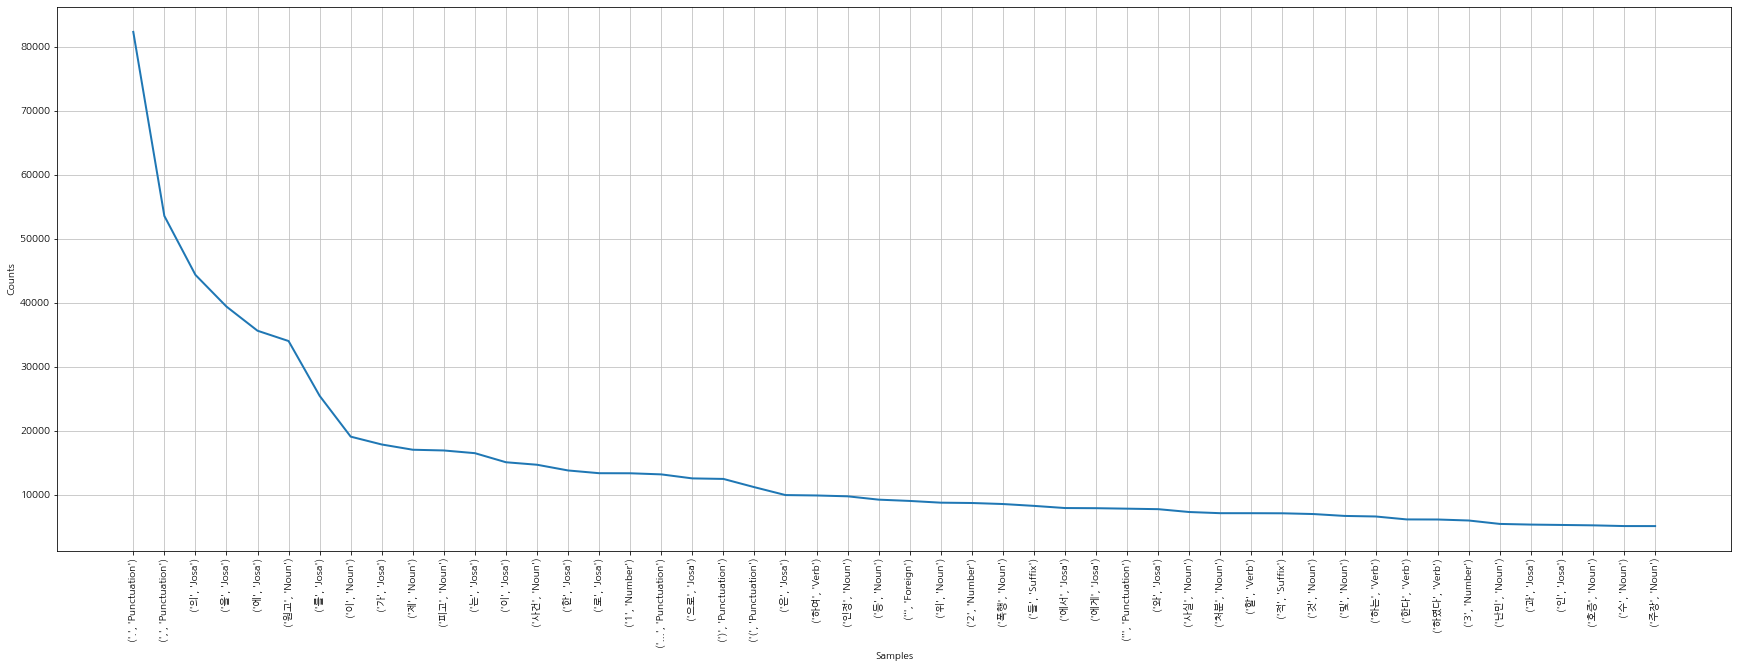

In [44]:
plt.figure(figsize=(30,10))
text.plot(50)

In [47]:
X_data = law_df['이유토큰화2']
y_data = law_df['승소여부']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3071,), (1024,), (3071,), (1024,))

In [49]:
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d in X_train]
test_x = [term_frequency(d) for d in X_test]
train_y = [c for c in y_train]
test_y = [c for c in y_test]

In [53]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

AttributeError: 'list' object has no attribute 'shape'

In [62]:
len(train_x[0])

1000

In [50]:
XX_train = np.asarray(train_x).astype('float32')
XX_test = np.asarray(test_x).astype('float32')

yy_train = np.asarray(train_y).astype('float32')
yy_test = np.asarray(test_y).astype('float32')

In [52]:
XX_train.shape, XX_test.shape, yy_train.shape, yy_test.shape

((3071, 1000), (1024, 1000), (3071,), (1024,))

In [54]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [59]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(XX_train, yy_train, epochs=10, batch_size=512)
results = model.evaluate(XX_test, yy_test)

Epoch 1/10
6/6 [==============================] - 0s 10ms/step - loss: 0.6799 - binary_accuracy: 0.6418
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4865 - binary_accuracy: 0.7551
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.4462 - binary_accuracy: 0.7747
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4147 - binary_accuracy: 0.7971
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.3962 - binary_accuracy: 0.8001
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.3718 - binary_accuracy: 0.8235
Epoch 7/10
6/6 [==============================] - 0s 5ms/step - loss: 0.3278 - binary_accuracy: 0.8577
Epoch 8/10
6/6 [==============================] - 0s 5ms/step - loss: 0.3532 - binary_accuracy: 0.8303
Epoch 9/10
6/6 [==============================] - 0s 5ms/step - loss: 0.2943 - binary_accuracy: 0.8727
Epoch 10/10
32/32 [==============================] - 0s 935us/step - lo

In [60]:
results

[0.46139416098594666, 0.7626953125]

# --------------- 똑같은 딥러닝시키는 것을 매개변수나 빈도수높은단어 숫자 같은 것을 조정해서 해봄 -----------

In [63]:
selected_words = [f[0] for f in text.vocab().most_common(3000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d in X_train]
test_x = [term_frequency(d) for d in X_test]
train_y = [c for c in y_train]
test_y = [c for c in y_test]

# 5분 걸림

In [64]:
XX_train = np.asarray(train_x).astype('float32')
XX_test = np.asarray(test_x).astype('float32')

yy_train = np.asarray(train_y).astype('float32')
yy_test = np.asarray(test_y).astype('float32')

In [65]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(XX_train, yy_train, epochs=10, batch_size=512)
results = model.evaluate(XX_test, yy_test)

Epoch 1/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6603 - binary_accuracy: 0.6239
Epoch 2/10
6/6 [==============================] - 0s 10ms/step - loss: 0.4442 - binary_accuracy: 0.7962
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3956 - binary_accuracy: 0.8186
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3472 - binary_accuracy: 0.8492
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.2937 - binary_accuracy: 0.8864
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.2775 - binary_accuracy: 0.8935
Epoch 7/10
6/6 [==============================] - 0s 11ms/step - loss: 0.2600 - binary_accuracy: 0.8958
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 0.1940 - binary_accuracy: 0.9375
Epoch 9/10
6/6 [==============================] - 0s 8ms/step - loss: 0.1918 - binary_accuracy: 0.9306
Epoch 10/10
32/32 [==============================] - 0s 1ms/step - loss

In [66]:
results # 정확도 0.78 

[0.4664199650287628, 0.779296875]

In [69]:
def tokenize(writing):
    return ['/'.join(t) for t in okt.pos(writing, norm=True, stem=True)]

In [80]:
def predict_pos_neg(review):

    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 승소이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 패소이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [83]:
predict_pos_neg('올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.')

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 51.88% 확률로 승소이지 않을까 추측해봅니다.^^



In [81]:
law_df['이유'].loc[10]

'... 기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 위와... 더보기 ... 따라서 피고는 원고에게 불법행위에 기한 손해배상으로 위자료 1,700만 원 및 이에 대하여 이 사건 소장 부본 송달 다음날인 2019. 11. 7.부터(원고는 불법행위의 시기인 2019. 9. 10.부터 지연손해금의 지급을 구한다고 주장하나, 원고의 청구는 부정행위 기간 전체에 대한 위자료 청구이고, 종기에 대한 주장, 입증이 없으므로, 이 사건 소장 부본 송달 다음날부터 지연손해금의 지급을 명한다) 이 판결 선고일인 2020. 10. 7.까지는 민법이 정한 연 5%, 그 다음날부터 다 갚는 날까지는 소송촉진 등에 관한 특례법이 정한 연 12%의 각 비율로 계산한 지연손해금을 지급할 의무가 있다. 3. 피고의 주장에 대한 판단 가. 주장의 요지 C와 원고의 혼인관계는 2019. 8.경부터 파탄 상태였다. 따라서, 피고와 C의 행위가 원고의 부부공동생활을 침해하거나 유지를 방해하였다고 할 수 없다. 나. 판단 을 제7호증, 갑 제11호증, 변론 전체의 취지를 종합하면, C가 2019. 10. 30. 인천가정법원 2019너16027호(2019드단115082호로 접수되었다가 재배당되었다)로 원고에 대하여 이혼 및 위자료 2,000만 원 지급을 구하는 조정신청을 한 사실, C는 신청원인으로 원고의 감정 기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 위와 같은 사정만으로는 피고와 C의 부정행위 당시 이미 원고와 C의 부부공동생활이 실질적으로 파탄되어 실체가 더 이상 존재하지 아니하게 되고 객관적으로 회복할 수 없는 정도에 이르렀다고 보기에 부족하고 달리 이를 인정할 증거가 없다. 따라서, 피고의 주장은 이유 없다. 4. 결론 원고의 청구는 위 인정범위 내에서 이유 있으므로 이를 인용하고, 나머지 청구는 이유 없으므로 이를 기각하기로 하여 주문과 같이 판결한다....'